<a href="https://colab.research.google.com/github/Xtian76/-MS-Progression-Prediction/blob/main/1d_y_d2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
"""
Notebook 00: Setup y Exploración Inicial del Dataset
=====================================================

TFM: Predicción Multimodal de Progresión en Esclerosis Múltiple
Autores: Cristian O. Saavedra Rodríguez, Gerardo Gómez-Moreno

Este notebook realiza:
1. Instalación de librerías necesarias
2. Configuración del entorno
3. Exploración inicial del dataset ISBI 2015
4. Visualización de imágenes de resonancia magnética
5. Análisis preliminar de metadatos
"""

# ============================================================================
# SECCIÓN 1: CONFIGURACIÓN DEL ENTORNO
# ============================================================================

print("=" * 80)
print("NOTEBOOK 00: SETUP Y EXPLORACIÓN INICIAL")
print("=" * 80)
print("\n🚀 Iniciando configuración del entorno...\n")


NOTEBOOK 00: SETUP Y EXPLORACIÓN INICIAL

🚀 Iniciando configuración del entorno...



In [24]:
# -----------------------------------------------------------------------------
# 1.1 Verificar si estamos en Google Colab
# -----------------------------------------------------------------------------

try:
    import google.colab
    IN_COLAB = True
    print("✓ Ejecutando en Google Colab")
except:
    IN_COLAB = False
    print("✓ Ejecutando en entorno local")

# -----------------------------------------------------------------------------
# 1.2 Montar Google Drive (solo en Colab)
# -----------------------------------------------------------------------------

if IN_COLAB:
    from google.colab import drive
    print("\n📁 Montando Google Drive...")
    drive.mount('/content/drive')
    print("✓ Google Drive montado correctamente")

    # Ruta base del proyecto en Drive
    BASE_PATH = '/content/drive/MyDrive/TFM/semana 1/ISBI'
else:
    BASE_PATH = '../'  # Ajustar según tu estructura local

print(f"\n📂 Ruta base del proyecto: {BASE_PATH}")

✓ Ejecutando en Google Colab

📁 Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive montado correctamente

📂 Ruta base del proyecto: /content/drive/MyDrive/TFM/semana 1/ISBI


In [25]:
# -----------------------------------------------------------------------------
# 1.3 Instalar librerías necesarias
# -----------------------------------------------------------------------------

print("\n📦 Instalando librerías necesarias...")
print("Esto puede tomar 2-3 minutos la primera vez...\n")

import sys

# Lista de paquetes a instalar
packages = [
    'nibabel',
    'nilearn',
    'SimpleITK',
    'scikit-image',
]

for package in packages:
    print(f"  Instalando {package}...")
    !pip install -q {package}

print("\n✓ Todas las librerías instaladas correctamente")



📦 Instalando librerías necesarias...
Esto puede tomar 2-3 minutos la primera vez...

  Instalando nibabel...
  Instalando nilearn...
  Instalando SimpleITK...
  Instalando scikit-image...

✓ Todas las librerías instaladas correctamente


In [26]:
# -----------------------------------------------------------------------------
# 1.5 Crear estructura de carpetas
# -----------------------------------------------------------------------------

print("\n📁 Creando estructura de carpetas...")

import os

# Definir estructura
folders = [
    'data/raw',
    'data/processed',
    'data/features',
    'notebooks',
    'results/figures',
    'results/metrics',
    'results/models',
    'docs'
]

for folder in folders:
    folder_path = os.path.join(BASE_PATH, folder)
    !mkdir -p "{folder_path}"

print("✓ Estructura de carpetas creada")
print("\nEstructura del proyecto:")
for folder in folders:
    print(f"  └── {folder}/")


📁 Creando estructura de carpetas...
✓ Estructura de carpetas creada

Estructura del proyecto:
  └── data/raw/
  └── data/processed/
  └── data/features/
  └── notebooks/
  └── results/figures/
  └── results/metrics/
  └── results/models/
  └── docs/


In [27]:
# ============================================================================
# SECCIÓN 2: CONFIGURACIÓN DE RUTAS Y PARÁMETROS
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURACIÓN DE RUTAS Y PARÁMETROS")
print("=" * 80 + "\n")

# Rutas principales
DATA_RAW = os.path.join(BASE_PATH, 'data/raw')
DATA_PROCESSED = os.path.join(BASE_PATH, 'data/processed')
RESULTS_FIGURES = os.path.join(BASE_PATH, 'results/figures')

print(f"📂 Datos crudos: {DATA_RAW}")
print(f"📂 Datos procesados: {DATA_PROCESSED}")
print(f"📂 Figuras: {RESULTS_FIGURES}")

# Parámetros del proyecto
PROJECT_CONFIG = {
    'dataset': 'ISBI 2015 Longitudinal MS Lesion Segmentation',
    'modalities': ['FLAIR', 'T1', 'T2'],
    'num_patients': 5,  # Dataset tiene 5 pacientes
    'timepoints_per_patient': [4, 5, 5, 4, 5],  # Aproximado
}

print("\n⚙️ Configuración del proyecto:")
for key, value in PROJECT_CONFIG.items():
    print(f"  • {key}: {value}")


CONFIGURACIÓN DE RUTAS Y PARÁMETROS

📂 Datos crudos: /content/drive/MyDrive/TFM/semana 1/ISBI/data/raw
📂 Datos procesados: /content/drive/MyDrive/TFM/semana 1/ISBI/data/processed
📂 Figuras: /content/drive/MyDrive/TFM/semana 1/ISBI/results/figures

⚙️ Configuración del proyecto:
  • dataset: ISBI 2015 Longitudinal MS Lesion Segmentation
  • modalities: ['FLAIR', 'T1', 'T2']
  • num_patients: 5
  • timepoints_per_patient: [4, 5, 5, 4, 5]


In [29]:
# ============================================================================
# SECCIÓN 3: FUNCIONES AUXILIARES
# ============================================================================

print("\n" + "=" * 80)
print("DEFINIENDO FUNCIONES AUXILIARES")
print("=" * 80 + "\n")

def load_nifti(filepath):
    """
    Carga un archivo NIfTI y retorna datos y metadatos

    Args:
        filepath: ruta al archivo .nii o .nii.gz

    Returns:
        data: array 3D con los datos de imagen
        affine: matriz de transformación afín
        header: información del header
    """
    try:
        img = nib.load(filepath)
        data = img.get_fdata()
        affine = img.affine
        header = img.header
        return data, affine, header
    except Exception as e:
        print(f"❌ Error cargando {filepath}: {str(e)}")
        return None, None, None


def get_nifti_info(filepath):
    """
    Extrae información básica de un archivo NIfTI

    Args:
        filepath: ruta al archivo

    Returns:
        dict con información del archivo
    """
    img = nib.load(filepath)
    header = img.header

    info = {
        'shape': img.shape,
        'voxel_size': header.get_zooms()[:3],
        'data_type': header.get_data_dtype(),
        'file_size_mb': os.path.getsize(filepath) / (1024**2),
    }

    return info


def plot_slice(data, slice_idx=None, axis=0, title="", cmap='gray', vmin=None, vmax=None):
    """
    Visualiza un slice 2D de una imagen 3D

    Args:
        data: array 3D
        slice_idx: índice del slice (None = slice central)
        axis: eje de corte (0=axial, 1=sagital, 2=coronal)
        title: título del plot
        cmap: colormap
    """
    if slice_idx is None:
        slice_idx = data.shape[axis] // 2

    if axis == 0:
        slice_data = data[slice_idx, :, :]
    elif axis == 1:
        slice_data = data[:, slice_idx, :]
    else:
        slice_data = data[:, :, slice_idx]

    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data.T, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(shrink=0.8)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def plot_3_views(data, title="", cmap='gray', vmin=None, vmax=None):
    """
    Visualiza las 3 vistas ortogonales (axial, sagital, coronal)

    Args:
        data: array 3D
        title: título principal
        cmap: colormap
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Slices centrales
    axial_slice = data.shape[0] // 2
    sagital_slice = data.shape[1] // 2
    coronal_slice = data.shape[2] // 2

    # Axial
    im1 = axes[0].imshow(data[axial_slice, :, :].T, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title('Vista Axial', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    # Sagital
    im2 = axes[1].imshow(data[:, sagital_slice, :].T, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    axes[1].set_title('Vista Sagital', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    # Coronal
    im3 = axes[2].imshow(data[:, :, coronal_slice].T, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax)
    axes[2].set_title('Vista Coronal', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2], shrink=0.8)

    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def overlay_lesions(image_data, lesion_mask, alpha=0.3):
    """
    Superpone máscara de lesiones sobre imagen

    Args:
        image_data: array 3D de la imagen base
        lesion_mask: array 3D de máscara binaria
        alpha: transparencia del overlay

    Returns:
        array 3D con overlay
    """
    # Normalizar imagen
    img_norm = (image_data - image_data.min()) / (image_data.max() - image_data.min())

    # Crear imagen RGB
    overlay = np.stack([img_norm, img_norm, img_norm], axis=-1)

    # Agregar lesiones en rojo
    lesion_coords = np.where(lesion_mask > 0)
    overlay[lesion_coords[0], lesion_coords[1], lesion_coords[2], 0] = 1.0  # R
    overlay[lesion_coords[0], lesion_coords[1], lesion_coords[2], 1] = 0.0  # G
    overlay[lesion_coords[0], lesion_coords[1], lesion_coords[2], 2] = 0.0  # B

    return overlay


def calculate_basic_stats(data):
    """
    Calcula estadísticas básicas de una imagen

    Args:
        data: array 3D

    Returns:
        dict con estadísticas
    """
    # Solo considerar voxels no-cero (dentro del cerebro)
    data_brain = data[data > 0]

    stats = {
        'min': float(np.min(data_brain)),
        'max': float(np.max(data_brain)),
        'mean': float(np.mean(data_brain)),
        'median': float(np.median(data_brain)),
        'std': float(np.std(data_brain)),
        'percentile_1': float(np.percentile(data_brain, 1)),
        'percentile_99': float(np.percentile(data_brain, 99)),
    }

    return stats


def count_lesion_voxels(lesion_mask):
    """
    Cuenta voxels de lesiones y calcula volumen

    Args:
        lesion_mask: array 3D binario

    Returns:
        dict con conteos
    """
    num_voxels = np.sum(lesion_mask > 0)

    # Asumiendo voxel size típico de 1x1x1 mm
    # (debería obtenerse del header real)
    voxel_volume_mm3 = 1.0
    total_volume_mm3 = num_voxels * voxel_volume_mm3

    return {
        'num_voxels': int(num_voxels),
        'volume_mm3': float(total_volume_mm3),
    }

print("✓ Funciones auxiliares definidas")


DEFINIENDO FUNCIONES AUXILIARES

✓ Funciones auxiliares definidas


In [31]:
# =============================================================================
# CELDA 4: Explorar estructura del dataset
# =============================================================================
print("🔍 Explorando estructura del dataset...\n")

# Listar archivos con la nueva ruta
data_path = "/content/drive/MyDrive/TFM/semana 1/ISBI"
files_list = []

for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            files_list.append(os.path.join(root, file))

print(f"📊 Total de archivos NIfTI encontrados: {len(files_list)}")

# Identificar imágenes FLAIR y máscaras
flair_images = [f for f in files_list if 'flair' in f.lower() or 'training' in f.lower()]
mask_images = [f for f in files_list if 'mask' in f.lower() or 'consensus' in f.lower()]

print(f" - Imágenes FLAIR: {len(flair_images)}")
print(f" - Máscaras de lesiones: {len(mask_images)}")

# Organizar en pares (imagen, máscara)
patient_data = []

for flair in flair_images:
    # Buscar máscara correspondiente
    patient_id = os.path.basename(flair).split('_')[0]
    mask = None

    for m in mask_images:
        if patient_id in m:
            mask = m
            break

    if mask:
        patient_data.append({
            'patient_id': patient_id,
            'flair_path': flair,
            'mask_path': mask
        })

import pandas as pd

df_patients = pd.DataFrame(patient_data)

print(f"\n✅ Pacientes con imágenes completas: {len(df_patients)}")
print("\n📋 Primeros pacientes:")
print(df_patients.head())

🔍 Explorando estructura del dataset...

📊 Total de archivos NIfTI encontrados: 210
 - Imágenes FLAIR: 210
 - Máscaras de lesiones: 42

✅ Pacientes con imágenes completas: 210

📋 Primeros pacientes:
   patient_id                                         flair_path  \
0  training02  /content/drive/MyDrive/TFM/semana 1/ISBI/train...   
1  training02  /content/drive/MyDrive/TFM/semana 1/ISBI/train...   
2  training02  /content/drive/MyDrive/TFM/semana 1/ISBI/train...   
3  training02  /content/drive/MyDrive/TFM/semana 1/ISBI/train...   
4  training02  /content/drive/MyDrive/TFM/semana 1/ISBI/train...   

                                           mask_path  
0  /content/drive/MyDrive/TFM/semana 1/ISBI/train...  
1  /content/drive/MyDrive/TFM/semana 1/ISBI/train...  
2  /content/drive/MyDrive/TFM/semana 1/ISBI/train...  
3  /content/drive/MyDrive/TFM/semana 1/ISBI/train...  
4  /content/drive/MyDrive/TFM/semana 1/ISBI/train...  


🖼️  Visualizando ejemplo de imagen FLAIR + máscara de lesiones...

📐 Dimensiones de la imagen FLAIR: (181, 217, 181)
📐 Dimensiones de la máscara: (181, 217, 181)
🧮 Tamaño del voxel: (np.float32(1.0), np.float32(1.0), np.float32(1.0))


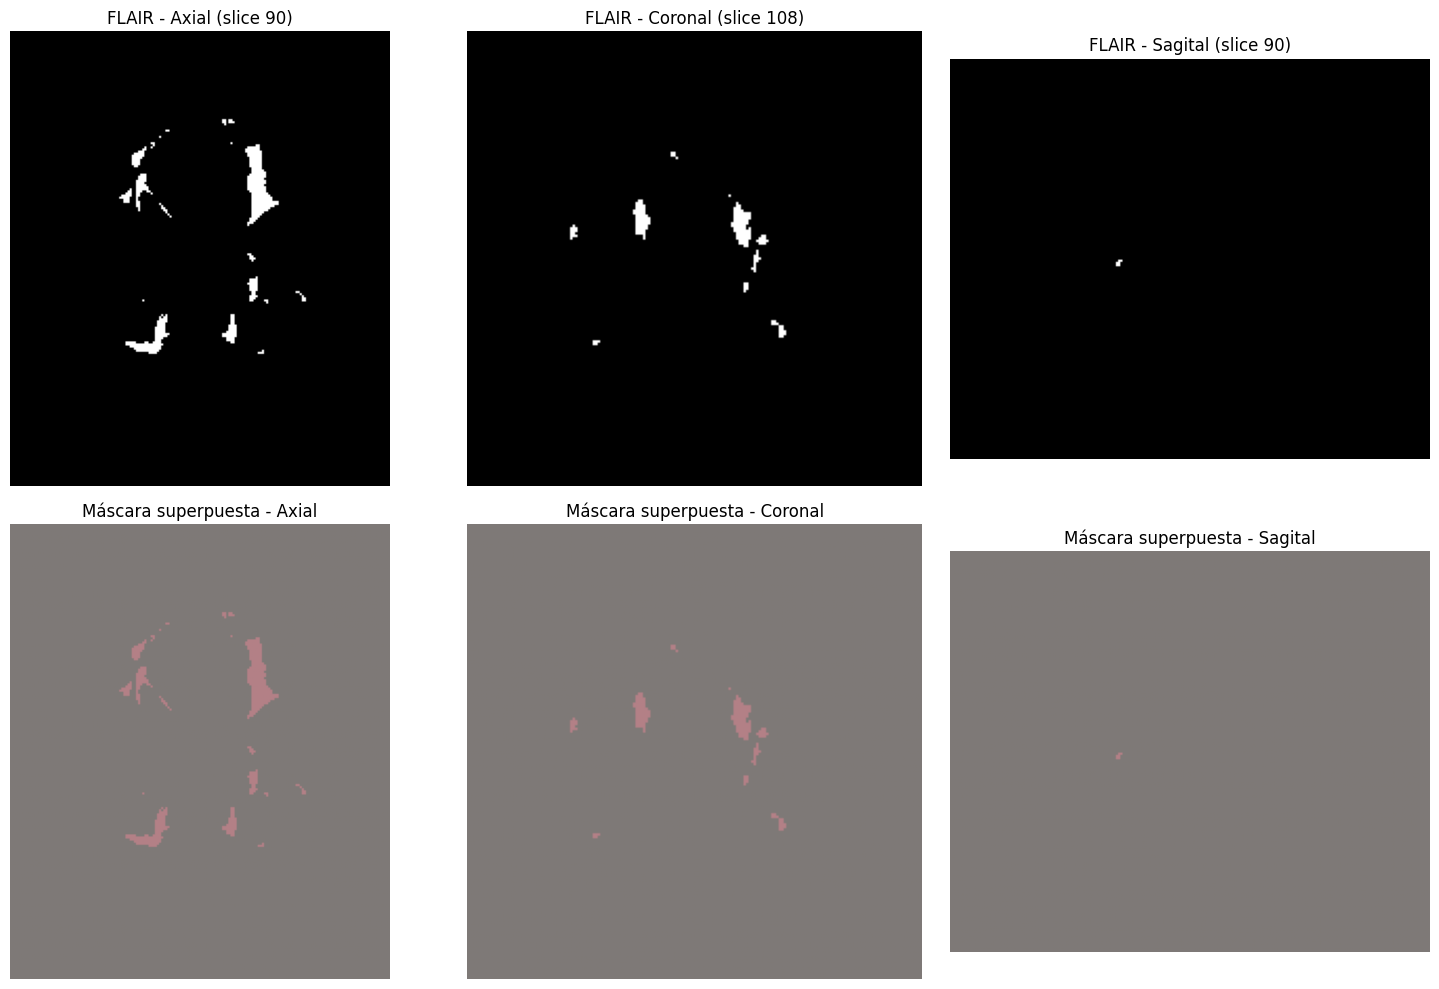

✅ Visualización guardada como 'ejemplo_visualizacion.png'


In [34]:
# =============================================================================
# CELDA 5: Visualizar ejemplo de imagen + máscara
# =============================================================================
print("🖼️  Visualizando ejemplo de imagen FLAIR + máscara de lesiones...\n")

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np # Added numpy import for array operations

# Cargar primer paciente
sample_idx = 0
flair_path = df_patients.iloc[sample_idx]['flair_path']
mask_path = df_patients.iloc[sample_idx]['mask_path']

# Cargar con nibabel
flair_img = nib.load(flair_path)
mask_img = nib.load(mask_path)

# Obtener datos como arrays
flair_data = flair_img.get_fdata()
mask_data = mask_img.get_fdata()

print(f"📐 Dimensiones de la imagen FLAIR: {flair_data.shape}")
print(f"📐 Dimensiones de la máscara: {mask_data.shape}")
print(f"🧮 Tamaño del voxel: {flair_img.header.get_zooms()}")

# Visualizar slice central en los 3 planos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Corte axial (vista superior)
slice_axial = flair_data.shape[2] // 2
axes[0, 0].imshow(flair_data[:, :, slice_axial].T, cmap='gray', origin='lower')
axes[0, 0].set_title(f'FLAIR - Axial (slice {slice_axial})')
axes[0, 0].axis('off')

axes[1, 0].imshow(flair_data[:, :, slice_axial].T, cmap='gray', origin='lower')
axes[1, 0].imshow(mask_data[:, :, slice_axial].T, cmap='Reds', alpha=0.5, origin='lower')
axes[1, 0].set_title('Máscara superpuesta - Axial')
axes[1, 0].axis('off')

# Corte coronal (vista frontal)
slice_coronal = flair_data.shape[1] // 2
axes[0, 1].imshow(flair_data[:, slice_coronal, :].T, cmap='gray', origin='lower')
axes[0, 1].set_title(f'FLAIR - Coronal (slice {slice_coronal})')
axes[0, 1].axis('off')

axes[1, 1].imshow(flair_data[:, slice_coronal, :].T, cmap='gray', origin='lower')
axes[1, 1].imshow(mask_data[:, slice_coronal, :].T, cmap='Reds', alpha=0.5, origin='lower')
axes[1, 1].set_title('Máscara superpuesta - Coronal')
axes[1, 1].axis('off')

# Corte sagital (vista lateral)
slice_sagital = flair_data.shape[0] // 2
axes[0, 2].imshow(flair_data[slice_sagital, :, :].T, cmap='gray', origin='lower')
axes[0, 2].set_title(f'FLAIR - Sagital (slice {slice_sagital})')
axes[0, 2].axis('off')

axes[1, 2].imshow(flair_data[slice_sagital, :, :].T, cmap='gray', origin='lower')
axes[1, 2].imshow(mask_data[slice_sagital, :, :].T, cmap='Reds', alpha=0.5, origin='lower')
axes[1, 2].set_title('Máscara superpuesta - Sagital')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('ejemplo_visualizacion.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualización guardada como 'ejemplo_visualizacion.png'")

In [35]:
# =============================================================================
# CELDA 6: Funciones para extracción de features clásicas
# =============================================================================
print("🔧 Definiendo funciones para extracción de biomarcadores...\n")

def calcular_volumen_voxel(nifti_image):
    """Calcula el volumen de un voxel en mm³"""
    voxel_dims = nifti_image.header.get_zooms()
    return np.prod(voxel_dims)

def extraer_features_basicas(mask_data, voxel_volume):
    """
    Extrae features básicas de la máscara de lesiones

    Returns:
        dict con features básicas
    """
    features = {}

    # 1. VOLUMEN TOTAL DE LESIONES
    num_voxels_lesion = np.sum(mask_data > 0)
    features['lesion_volume_mm3'] = num_voxels_lesion * voxel_volume
    features['lesion_volume_ml'] = features['lesion_volume_mm3'] / 1000

    # 2. NÚMERO DE LESIONES (componentes conectados)
    labeled_mask, num_lesions = ndimage.label(mask_data > 0)
    features['num_lesions'] = num_lesions

    # 3. TAMAÑO MEDIO DE LESIÓN
    if num_lesions > 0:
        features['mean_lesion_size_mm3'] = features['lesion_volume_mm3'] / num_lesions
    else:
        features['mean_lesion_size_mm3'] = 0

    # 4. LESIÓN MÁS GRANDE
    if num_lesions > 0:
        lesion_sizes = ndimage.sum(mask_data, labeled_mask, range(1, num_lesions + 1))
        features['largest_lesion_mm3'] = np.max(lesion_sizes) * voxel_volume
    else:
        features['largest_lesion_mm3'] = 0

    # 5. LESIÓN MÁS PEQUEÑA
    if num_lesions > 0:
        features['smallest_lesion_mm3'] = np.min(lesion_sizes) * voxel_volume
    else:
        features['smallest_lesion_mm3'] = 0

    return features, labeled_mask

def extraer_features_distribucion_espacial(mask_data, labeled_mask, num_lesions):
    """
    Analiza la distribución espacial de las lesiones
    """
    features = {}

    if num_lesions == 0:
        features['centroid_x'] = 0
        features['centroid_y'] = 0
        features['centroid_z'] = 0
        features['spatial_spread_x'] = 0
        features['spatial_spread_y'] = 0
        features['spatial_spread_z'] = 0
        return features

    # Centro de masa de todas las lesiones
    centroid = ndimage.center_of_mass(mask_data)
    features['centroid_x'] = centroid[0]
    features['centroid_y'] = centroid[1]
    features['centroid_z'] = centroid[2]

    # Dispersión espacial (desviación estándar de las posiciones)
    coords = np.argwhere(mask_data > 0)
    if len(coords) > 0:
        features['spatial_spread_x'] = np.std(coords[:, 0])
        features['spatial_spread_y'] = np.std(coords[:, 1])
        features['spatial_spread_z'] = np.std(coords[:, 2])
    else:
        features['spatial_spread_x'] = 0
        features['spatial_spread_y'] = 0
        features['spatial_spread_z'] = 0

    # Distribución por terciles (superior, medio, inferior del cerebro)
    z_shape = mask_data.shape[2]
    tercil_inferior = mask_data[:, :, :z_shape//3]
    tercil_medio = mask_data[:, :, z_shape//3:2*z_shape//3]
    tercil_superior = mask_data[:, :, 2*z_shape//3:]

    features['lesions_inferior_third'] = np.sum(tercil_inferior > 0)
    features['lesions_middle_third'] = np.sum(tercil_medio > 0)
    features['lesions_superior_third'] = np.sum(tercil_superior > 0)

    return features

def extraer_features_intensidad(flair_data, mask_data):
    """
    Extrae estadísticas de intensidad en las regiones de lesión
    """
    features = {}

    # Intensidades en las lesiones
    lesion_intensities = flair_data[mask_data > 0]

    if len(lesion_intensities) > 0:
        features['lesion_intensity_mean'] = np.mean(lesion_intensities)
        features['lesion_intensity_std'] = np.std(lesion_intensities)
        features['lesion_intensity_median'] = np.median(lesion_intensities)
        features['lesion_intensity_min'] = np.min(lesion_intensities)
        features['lesion_intensity_max'] = np.max(lesion_intensities)
        features['lesion_intensity_q25'] = np.percentile(lesion_intensities, 25)
        features['lesion_intensity_q75'] = np.percentile(lesion_intensities, 75)
    else:
        features['lesion_intensity_mean'] = 0
        features['lesion_intensity_std'] = 0
        features['lesion_intensity_median'] = 0
        features['lesion_intensity_min'] = 0
        features['lesion_intensity_max'] = 0
        features['lesion_intensity_q25'] = 0
        features['lesion_intensity_q75'] = 0

    # Contraste entre lesión y tejido sano
    healthy_tissue = flair_data[mask_data == 0]
    if len(healthy_tissue) > 0 and len(lesion_intensities) > 0:
        features['lesion_contrast'] = np.mean(lesion_intensities) - np.mean(healthy_tissue)
    else:
        features['lesion_contrast'] = 0

    return features

def extraer_features_forma(labeled_mask, num_lesions, voxel_volume):
    """
    Extrae características de forma y textura de las lesiones
    """
    features = {}

    if num_lesions == 0:
        features['mean_sphericity'] = 0
        features['mean_elongation'] = 0
        features['mean_compactness'] = 0
        return features

    sphericities = []
    elongations = []
    compactnesses = []

    for lesion_id in range(1, min(num_lesions + 1, 50)):  # Limitar a 50 para velocidad
        lesion_mask = (labeled_mask == lesion_id)

        # Calcular propiedades con scikit-image
        props = measure.regionprops(lesion_mask.astype(int))

        if len(props) > 0:
            prop = props[0]

            # Esfericidad aproximada
            volume = prop.area * voxel_volume
            surface_area = prop.perimeter * np.sqrt(voxel_volume)  # Aproximación 2D
            if surface_area > 0:
                sphericity = (np.pi ** (1/3)) * ((6 * volume) ** (2/3)) / surface_area
                sphericities.append(min(sphericity, 1.0))

            # Elongación (ratio de ejes principales)
            if prop.major_axis_length > 0:
                elongation = prop.minor_axis_length / prop.major_axis_length
                elongations.append(elongation)

            # Compacidad
            if prop.area > 0:
                compactness = (prop.perimeter ** 2) / (4 * np.pi * prop.area)
                compactnesses.append(compactness)

    features['mean_sphericity'] = np.mean(sphericities) if sphericities else 0
    features['mean_elongation'] = np.mean(elongations) if elongations else 0
    features['mean_compactness'] = np.mean(compactnesses) if compactnesses else 0

    return features

def extraer_todas_las_features(flair_path, mask_path, patient_id):
    """
    Pipeline completo de extracción de features para un paciente
    """
    try:
        # Cargar imágenes
        flair_img = nib.load(flair_path)
        mask_img = nib.load(mask_path)

        flair_data = flair_img.get_fdata()
        mask_data = mask_img.get_fdata()

        # Calcular volumen del voxel
        voxel_volume = calcular_volumen_voxel(mask_img)

        # Diccionario para todas las features
        all_features = {'patient_id': patient_id}

        # 1. Features básicas
        features_basicas, labeled_mask = extraer_features_basicas(mask_data, voxel_volume)
        all_features.update(features_basicas)

        # 2. Distribución espacial
        features_espacial = extraer_features_distribucion_espacial(
            mask_data, labeled_mask, features_basicas['num_lesions']
        )
        all_features.update(features_espacial)

        # 3. Features de intensidad
        features_intensidad = extraer_features_intensidad(flair_data, mask_data)
        all_features.update(features_intensidad)

        # 4. Features de forma
        features_forma = extraer_features_forma(
            labeled_mask, features_basicas['num_lesions'], voxel_volume
        )
        all_features.update(features_forma)

        return all_features

    except Exception as e:
        print(f"❌ Error procesando paciente {patient_id}: {str(e)}")
        return None

print("✅ Funciones definidas correctamente")
print(f"📊 Total de funciones: 5")
print(f"   - Features básicas (volumen, número lesiones)")
print(f"   - Distribución espacial (centroide, dispersión)")
print(f"   - Intensidad (media, contraste)")
print(f"   - Forma (esfericidad, elongación)")


🔧 Definiendo funciones para extracción de biomarcadores...

✅ Funciones definidas correctamente
📊 Total de funciones: 5
   - Features básicas (volumen, número lesiones)
   - Distribución espacial (centroide, dispersión)
   - Intensidad (media, contraste)
   - Forma (esfericidad, elongación)


In [36]:
# =============================================================================
# CELDA 7: Extraer features de TODOS los pacientes
# =============================================================================
print("🚀 Iniciando extracción de features para todos los pacientes...\n")
print(f"📊 Total de pacientes a procesar: {len(df_patients)}")
print("⏱️  Tiempo estimado: ~30 segundos por paciente\n")

all_patient_features = []

for idx, row in df_patients.iterrows():
    patient_id = row['patient_id']
    flair_path = row['flair_path']
    mask_path = row['mask_path']

    print(f"Procesando {idx+1}/{len(df_patients)}: {patient_id}...", end=" ")

    features = extraer_todas_las_features(flair_path, mask_path, patient_id)

    if features:
        all_patient_features.append(features)
        print(f"✅ ({features['num_lesions']} lesiones, {features['lesion_volume_ml']:.2f} ml)")
    else:
        print("❌")

# Crear DataFrame con todas las features
df_features = pd.DataFrame(all_patient_features)

print(f"\n✅ Extracción completada!")
print(f"📊 Total de pacientes procesados: {len(df_features)}")
print(f"📊 Total de features extraídas: {len(df_features.columns) - 1}")

🚀 Iniciando extracción de features para todos los pacientes...

📊 Total de pacientes a procesar: 210
⏱️  Tiempo estimado: ~30 segundos por paciente

Procesando 1/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 2/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 3/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 4/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 5/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 6/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 7/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 8/210: training02... ❌ Error procesando paciente training02: name 'ndimage' is not defined
❌
Procesando 9/210: t